# OpenCV Face Recognition

The Face Recognition process in this tutorial is divided into three steps.

1. **Prepare training data:** In this step we will read training images for each person/subject along with their labels, detect faces from each image and assign each detected face an integer label of the person it belongs to.
2. **Train Face Recognizer:** In this step we will train OpenCV's LBPH face recognizer by feeding it the data we prepared in step 1.
3. **Testing:** In this step we will pass some test images to face recognizer and see if it predicts them correctly.

To detect faces, I will use the code from my previous article on [face detection](https://www.superdatascience.com/opencv-face-detection/). So if you have not read it, I encourage you to do so to understand how face detection works and its Python coding. 

## Import Required Modules

- **cv2:** is _OpenCV_ module for Python which we will use for face detection and face recognition.
- **os:** We will use this Python module to read our training directories and file names.
- **numpy:** We will use this module to convert Python lists to numpy arrays as OpenCV face recognizers accept numpy arrays.

In [1]:
#import OpenCV module
import cv2
#import os module for reading training data directories and paths
import os
#import numpy to convert python lists to numpy arrays as 
#it is needed by OpenCV face recognizers
import numpy as np

#matplotlib for display our images
import matplotlib.pyplot as plt
%matplotlib inline 

The more images used in training the better. Normally a lot of images are used for training a face recognizer so that it can learn different looks of the same person, for example with glasses, without glasses, laughing, sad, happy, crying, with beard, without beard etc. To keep our tutorial simple we are going to use only 12 images for each person. 

So our training data consists of total 2 persons with 12 images of each person. All training data is inside _`training-data`_ folder. _`training-data`_ folder contains one folder for each person and **each folder is named with format `sLabel (e.g. s1, s2)` where label is actually the integer label assigned to that person**. For example folder named s1 means that this folder contains images for person 1. The directory structure tree for training data is as follows:

```
training-data
|-------------- s1
|               |-- 1.jpg
|               |-- ...
|               |-- 12.jpg
|-------------- s2
|               |-- 1.jpg
|               |-- ...
|               |-- 12.jpg
```

The _`test-data`_ folder contains images that we will use to test our face recognizer after it has been successfully trained.

As OpenCV face recognizer accepts labels as integers so we need to define a mapping between integer labels and persons actual names so below I am defining a mapping of persons integer labels and their respective names. 

**Note:** As we have not assigned `label 0` to any person so **the mapping for label 0 is empty**. 

In [2]:
#there is no label 0 in our training data so subject name for index/label 0 is empty
subjects = ["", "Tom Cruise", "Shahrukh Khan"]

### Prepare training data

You may be wondering why data preparation, right? Well, OpenCV face recognizer accepts data in a specific format. It accepts two vectors, one vector is of faces of all the persons and the second vector is of integer labels for each face so that when processing a face the face recognizer knows which person that particular face belongs too. 

For example, if we had 2 persons and 2 images for each person. 

```
PERSON-1    PERSON-2   

img1        img1         
img2        img2
```

Then the prepare data step will produce following face and label vectors.

```
FACES                        LABELS

person1_img1_face              1
person1_img2_face              1
person2_img1_face              2
person2_img2_face              2
```


Preparing data step can be further divided into following sub-steps.

1. Read all the folder names of subjects/persons provided in training data folder. So for example, in this tutorial we have folder names: `s1, s2`. 
2. For each subject, extract label number. **Do you remember that our folders have a special naming convention?** Folder names follow the format `sLabel` where `Label` is an integer representing the label we have assigned to that subject. So for example, folder name `s1` means that the subject has label 1, s2 means subject label is 2 and so on. The label extracted in this step is assigned to each face detected in the next step. 
3. Read all the images of the subject, detect face from each image.
4. Add each face to faces vector with corresponding subject label (extracted in above step) added to labels vector. 

In [3]:
#function to detect face using OpenCV
def detect_face(img):
    #load OpenCV face detector, I am using LBP which is fast
    #there is also a more accurate but slow Haar classifier
    face_cascade = cv2.CascadeClassifier('opencv-files/lbpcascade_frontalface.xml')
    
    #img_copy = np.copy(colored_img)
    
    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #gray = np.array(gray, "uint8")
    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    
    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

In [4]:
#this function will read all persons' training images, detect face from each image
#and will return two lists of exactly same size, one list 
# of faces and another list of labels for each face
def prepare_training_data(data_folder_path):
    
    #list the directories (one directory for each subject) in data folder
    dirs = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in dirs:
        
        #our subject directories start with letter 's' so
        #ignore any non-relevant directories if any
        if not dir_name.startswith("s"):
            continue;
            
        #extract label number of subject from dir_name
        #format of dir name = slabel
        #, so removing letter 's' from dir_name will give us label
        label = int(dir_name.replace("s", ""))
        
        #build path of directory containin images for current subject subject
        #sample subject_dir_path = "training-data/s1"
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)
        
        #go through each image name, read image, 
        #detect face and add face to list of faces
        for image_name in subject_images_names:
            
            #ignore system files like .DS_Store
            if image_name.startswith("."):
                continue;
            
            #build image path
            #sample image path = training-data/s1/1.pgm
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path)
            
            #display an image window to show the image 
            cv2.imshow("Training on image...", image)
            cv2.waitKey(100)
            
            #detect face
            face, rect = detect_face(image)
            
            #for the purpose of this tutorial
            #we will ignore faces that are not detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    
    return faces, labels

### Train Face Recognizer

In [5]:
#let's first prepare our training data
#data will be in two lists of same size
#one list will contain all the faces
#and other list will contain respective labels for each face
print("Preparing data...")
faces, labels = prepare_training_data("training-data")
print("Data prepared")

#print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...
Data prepared
Total faces:  23
Total labels:  23


In [6]:
#create our LBPH face recognizer 
face_recognizer = cv2.face.createLBPHFaceRecognizer()

In [7]:
#train our face recognizer of our training faces
face_recognizer.train(faces, np.array(labels))

### Prediction

In [8]:
#function to draw rectangle on image 
#according to given (x, y) coordinates and 
#given width and heigh
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
#function to draw text on give image starting from
#passed (x, y) coordinates. 
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

In [9]:
#this function recognizes the person in image passed
#and draws a rectangle around detected face with name of the 
#subject
def predict(test_img):
    #make a copy of the image as we don't want to chang original image
    img = test_img.copy()
    #detect face from the image
    face, rect = detect_face(img)

    #predict the image using our face recognizer 
    label= face_recognizer.predict(face)
    #get name of respective label returned by face recognizer
    label_text = subjects[label]
    
    #draw a rectangle around face detected
    draw_rectangle(img, rect)
    #draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)
    
    return img

Predicting images...
Prediction complete


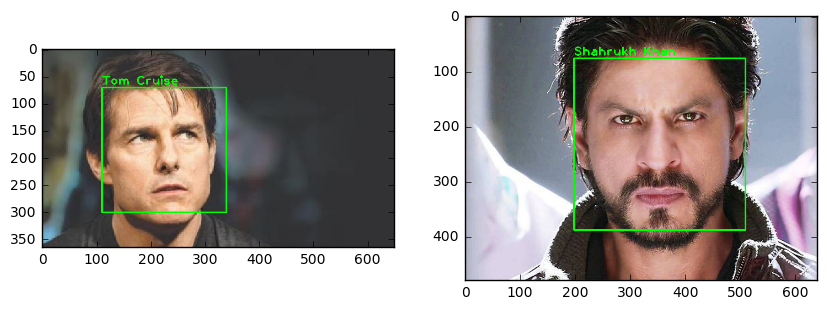

In [10]:
print("Predicting images...")

#load test images
test_img1 = cv2.imread("test-data/test1.jpg")
test_img2 = cv2.imread("test-data/test2.jpg")

#perform a prediction
predicted_img1 = predict(test_img1)
predicted_img2 = predict(test_img2)
print("Prediction complete")

#create a figure of 2 plots (one for each test image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#display test image1 result
ax1.imshow(cv2.cvtColor(predicted_img1, cv2.COLOR_BGR2RGB))

#display test image2 result
ax2.imshow(cv2.cvtColor(predicted_img2, cv2.COLOR_BGR2RGB))

#display both images
cv2.imshow("Tom cruise test", predicted_img1)
cv2.imshow("Shahrukh Khan test", predicted_img2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.destroyAllWindows()